In [1]:
def create_best_lstm_model(best_params):
    model = Sequential()
    n_layers = best_params['lstm_n_layers']
    units = best_params['lstm_units']
    for i in range(n_layers):
        model.add(LSTM(
            units=units,
            return_sequences=(i < n_layers - 1),
            input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]) if i == 0 else None
        ))
        model.add(Dropout(rate=best_params['lstm_dropout']))
    model.add(Dense(1))
    learning_rate = best_params['lstm_learning_rate']
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model


def create_lstm_model(trial):
    model = Sequential()
    n_layers = trial.suggest_int('lstm_n_layers', 2, 4)  # 优化 LSTM 层数
    units = trial.suggest_categorical('lstm_units', [50, 100, 150, 200])
    for i in range(n_layers):
        model.add(LSTM(
            units=units,
            return_sequences=(i < n_layers - 1),
            input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]) if i == 0 else None
        ))
        dropout_rate = trial.suggest_categorical('lstm_dropout', [0,0.1, 0.2, 0.3, 0.4, 0.5])
        model.add(Dropout(rate=dropout_rate))  # 使用特定的 Dropout 丢弃率
    model.add(Dense(1))
    learning_rate = trial.suggest_categorical('lstm_learning_rate', [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001])  # 优化学习率
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# 定义优化目标函数
def objective_LSTM(trial):
    num_samples = X_train_lstm.shape[0]*0.8
    batch_size_candidates = [16, 32, 64, 128, 256, 512,1024,2048]#
    batch_size_candidates = [bs for bs in batch_size_candidates if bs <= num_samples]
    param = {
        'epochs': trial.suggest_categorical('lstm_epochs', [10, 20, 30, 40, 50, 75, 100, 150, 200]),#
        'batch_size': trial.suggest_categorical('lstm_batch_size', batch_size_candidates)
    }
    param['batch_size'] = min(param['batch_size'], num_samples) # # 确保 batch_size 不大于训练数据集的样本量
    model = KerasRegressor(build_fn=lambda: create_lstm_model(trial), epochs=param['epochs'], batch_size=param['batch_size'], verbose=0) #
    
    
    # 使用五折交叉验证
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_scores = []
    
    for train_index, val_index in kf.split(X_train_lstm):
        X_train, X_val = X_train_lstm[train_index], X_train_lstm[val_index]
        y_train_fold, y_val = y_train[train_index], y_train[val_index]
        num_samples = X_train.shape[0]
        # 'patience' 参数定义了在停止前，模型在多少个epoch内没有改进时继续训练
        # 'restore_best_weights' 如果为True，模型的权重会被恢复到验证损失最低的点
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        model.fit(X_train, y_train_fold, validation_data=(X_val, y_val), callbacks=[early_stopping, KerasPruningCallback(trial, 'val_loss')])
        
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        mse_scores.append(mse)
    
    return np.mean(mse_scores)


def plot_importance(df_importances, output_path, model_name, region,filename):
    
    """
    绘制特征重要性的条形图和同心饼图。

    参数:
        df_importances (DataFrame): 特征重要性数据，要求包含 'feature' 列。
        output_path (str): 输出路径的基础路径。
        model_name (str): 模型名称，将用于文件夹结构和文件命名。
        region (str): 区域名，将用于输出文件名。
        category_map (dict): 特征到类别的映射字典。
    """
    # 按照特征分类
    # 特征对应的类别
    category_map = {
        'KNDVI': 'VI',
        'EVI': 'VI',
        'NDVI': 'VI',
        'modis_Gpp': 'VI',
        'Fpar': 'VI',
        'modis_LAI': 'VI',
        'PML_Gpp': 'VI',
        'Mean_Yield': 'TI',
        'Previous_Yield': 'TI',
        'year': 'TI',
        'Pre': 'MC',
        'Tmin': 'MC',
        'Solar': 'MC',
        'Tmean': 'MC',
        'Tmax': 'MC',
        'CDD': 'EC',
        'HDD': 'EC',
        'GDD': 'EC',
        'VPD': 'EC',
        'SPEI': 'EC',
        'wind_speed': 'EC',
        'SAND': 'CEC',
        'AWC': 'CEC',
        'SILT': 'CEC',
        'ORG_CARBON': 'CEC',
        'TOTAL_N': 'CEC',
        'PH_WATER': 'CEC',
        'CEC_SOIL': 'CEC',
        'CLAY': 'CEC',
        'elevation': 'CEC',
        'lat': 'CEC',
         'lon': 'CEC'
    }
    # 设置文件保存路径
    folder_path = os.path.join(output_path, '06_figure', 'results', model_name)
    os.makedirs(folder_path, exist_ok=True)

    # 计算特征贡献度均值
    df_importances_mean = df_importances.mean(axis=1).reset_index()
    df_importances_mean['Category'] = df_importances_mean['feature'].map(category_map)
    df_importances_mean = df_importances_mean[['feature', 0, 'Category']]
    df_importances_mean.columns = ['Feature', 'Contribution', 'Category']

    # 排除基准特征并按类别和贡献度排序
    contribution_df_sorted = df_importances_mean[df_importances_mean['Feature'] != 'BASELINE']
    contribution_df_sorted = contribution_df_sorted.sort_values(by=['Category', 'Contribution'], ascending=[True, False])

    # 定义类别颜色和渐变函数
    category_colors = {
        'VI': (0.9, 0.7, 0.2, 1),  # 黄色
        'TI': (0.6, 0.3, 0.9, 1),  # 紫色
        'MC': (0.7, 0.3, 0.3, 1),  # 暗红
        'EC': (0.2, 0.9, 0.9, 1),  # 青色
        'CEC': (0.3, 0.6, 0.9, 1)  # 浅蓝
    }
    default_color = (0.8, 0.8, 0.8, 1)  # 灰色

    def get_color_gradient(base_color, num_shades):
        gradient = np.linspace(0.4, 1, num_shades)
        return [(base_color[0], base_color[1], base_color[2], shade) for shade in gradient]

    # 内圈和外圈数据
    inner_contribution = contribution_df_sorted.groupby('Category')['Contribution'].sum()
    outer_contribution = contribution_df_sorted.set_index('Feature')['Contribution']

    # 为外圈创建颜色渐变
    outer_colors = []
    for category in inner_contribution.index:
        category_df = contribution_df_sorted[contribution_df_sorted['Category'] == category]
        base_color = category_colors.get(category, default_color)
        gradient_colors = get_color_gradient(base_color, len(category_df))
        outer_colors.extend(gradient_colors)

    # 绘制图形
    fig, ax = plt.subplots(figsize=(10, 8), dpi=1200)
    ax.set_facecolor('#f0f0f0')
    ax.grid(True, which='both', linestyle='--', linewidth=0.7, color='gray', alpha=0.7)

    # 绘制条形图
    contribution_df_sorted = contribution_df_sorted.sort_values(by='Contribution', ascending=False)
    bar_colors = [category_colors.get(cat, default_color) for cat in contribution_df_sorted['Category']]
    ax.barh(contribution_df_sorted['Feature'], contribution_df_sorted['Contribution'], color=bar_colors)
    ax.set_xlabel('Contribution')
    ax.set_ylabel('Feature')
    ax.set_title('Feature Contributions by Category')
    ax.invert_yaxis()

    # 添加图例
    handles = [plt.Rectangle((0, 0), 1, 1, color=category_colors[cat]) for cat in category_colors]
    ax.legend(handles, category_colors.keys(), loc='lower right')

    # 绘制嵌入的同心饼图
    inset_ax = inset_axes(ax, width=2, height=2, loc='upper right', bbox_to_anchor=(0.8, 0.35, 0.2, 0.2), bbox_transform=ax.transAxes)
    inset_ax.pie(inner_contribution, labels=[''] * len(inner_contribution), autopct='%1.1f%%', radius=1,
                 colors=[category_colors.get(cat, default_color) for cat in inner_contribution.index], wedgeprops=dict(width=0.3, edgecolor='w'))
    inset_ax.pie(outer_contribution, labels=[''] * len(outer_contribution), radius=0.7, colors=outer_colors, wedgeprops=dict(width=0.3, edgecolor='w'))
    inset_ax.add_artist(plt.Circle((0, 0), 0.4, color='white'))

    # 保存图表
    plt.savefig(filename, format='tiff', bbox_inches='tight')
    plt.show()

def plt_scatter(data,filename):
    dataframes = data[['predicts','records']]
    dataframes1 = dataframes
    r2 = r2_score(dataframes['records'], dataframes['predicts'])  
    # 计算NRMSE  
    mse = mean_squared_error(dataframes['records'], dataframes['predicts'])  
    nrmse = np.sqrt(mse) / np.mean(dataframes['records'])  
    rrmse = calculate_rrmse1(dataframes['records'], dataframes['predicts'])
    
    mape = mean_absolute_percentage_error(dataframes['records'], dataframes['predicts'])
    acc = calculate_acc(dataframes['records'], dataframes['predicts'])
    plt.figure(figsize=(10, 6))
    plt.hexbin(dataframes['records'], dataframes['predicts'], gridsize=50, cmap='viridis', mincnt=1)
    cb = plt.colorbar(label='Density')
    fit_params = np.polyfit(dataframes['records'], dataframes['predicts'], 1)
    fit_line = np.polyval(fit_params, dataframes['records'])
    plt.plot(dataframes['records'], fit_line, color='red', label='Fit line')# 添加1:1线
    max_val = max(max(dataframes['records']), max(dataframes['predicts']))
    plt.plot([0, max_val], [0, max_val], linestyle='--', color='green', label='1:1 line')
    plt.title('')
    plt.xlabel('records')
    plt.ylabel('predicts')
    plt.grid(True)
    plt.text(0.02, 0.95, f'R² = {r2:.2f}', transform=plt.gca().transAxes, fontsize=12, va='top')  
    plt.text(0.02, 0.90, f'ACC = {acc:.2f}', transform=plt.gca().transAxes, fontsize=12, va='top')  
    plt.text(0.02, 0.85, f'RRMSE = {rrmse:.2f}%', transform=plt.gca().transAxes, fontsize=12, va='top')  
    plt.text(0.02, 0.80, f'MAPE = {mape*100:.2f}%', transform=plt.gca().transAxes, fontsize=12, va='top')  
    
    # 显示图形  
    plt.savefig(filename)
    plt.show()




In [2]:
import os
import sys
import ast
root_directory = os.getcwd()[0:3]
sys.path.append(root_directory+'SCI\\SCI9\\2_DataAnalysis\\04_code\\1_04_Soybean')
sys.path.append(r'C:\ProgramData\anaconda3\Lib\site-packages') 
sys.path.append(r'C:\Users\DELL\.conda\envs\myenv\Lib\site-packages') 
sys.path.append(r'C:\Users\DELL\.conda\envs\rasterio_env\Lib\site-packages') 
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.preprocessing import StandardScaler
from functions import prepare_and_model_data,extract_selected_variables
from functions import calculate_rrmse1,calculate_rrmse2,calculate_acc
from sklearn.metrics import r2_score


import optuna
from optuna_integration.keras import KerasPruningCallback
from optuna.samplers import TPESampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_percentage_error
from functions import calculate_rrmse1,calculate_rrmse2,calculate_acc,calculate_nrmse
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.model_selection import train_test_split


# 需要修改下
countryID = '06_India';
country =countryID[3:]
crop = '02_wheat';yield_type= 'actual_yield';
inputpath_base = root_directory + '\\SCI\\SCI9_1\\02_data\\'+crop+'\\'+countryID
root_directory = os.getcwd()[0:3]
inpath_dates_other = root_directory + '\\SCI\\SCI9_1\\02_data\\'+crop+'\\'+countryID+'\\'+'01_data'+'\\'+'07_Information'
other_infornamtion = pd.read_csv(os.path.join(inpath_dates_other,'information.txt'), sep=' ', header=None)
startyear,endyear,shp_name = other_infornamtion.iloc[0,0],other_infornamtion.iloc[0,1],other_infornamtion.iloc[0,2]
regions = ['I']
Forecastyear = endyear
# 定义每个区的最佳预报年
Forecastyears = {
    'I': Forecastyear}


years = range(startyear,endyear+1)
years_str = [str(year) for year in years]
modelname = 'LSTM'
yield_type = 'actual_yield';
SelFeature_infornamtion = extract_selected_variables(inputpath_base)
institution = 'ECMWF';

  0%|          | 0/17 [00:00<?, ?it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


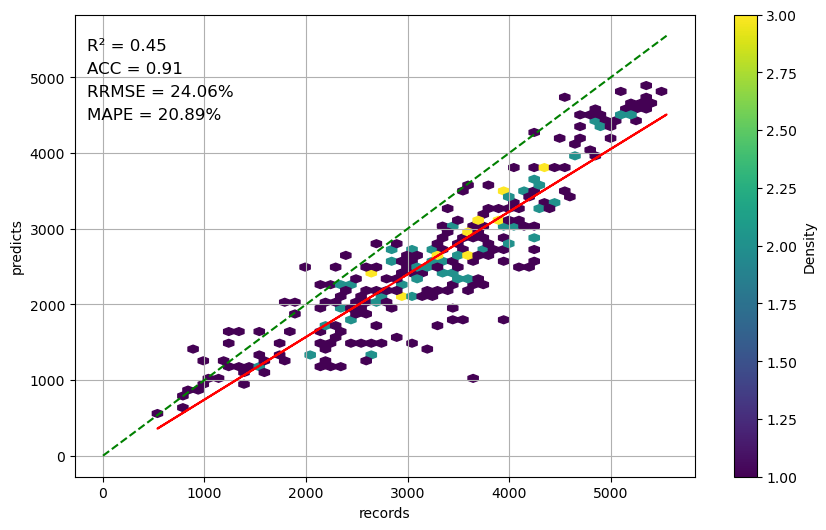

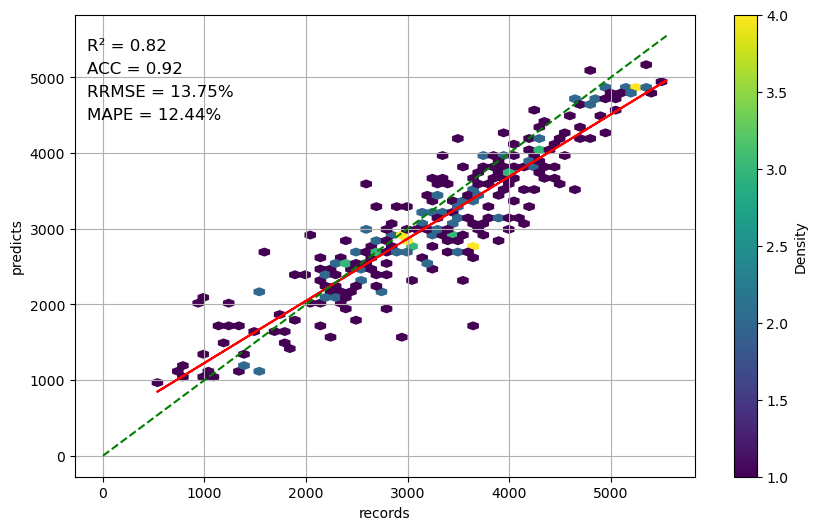

In [ ]:
for region in regions:
    ###################读取所选因子变量#########################################
    Forecastyear = Forecastyears[region]
    data= pd.read_csv(os.path.join(inputpath_base, '01_data','05_buildmodel','05_modeldataNew',region+'_data_new.csv'))
    # data= pd.read_csv(os.path.join(inputpath_base, '01_data','05_buildmodel','03_modeldata',region+'_data_ori.csv'))
    data = data.drop_duplicates(subset=['year', 'idJoin'], keep='first')
    TimeFeatures_sel, Static_sel, regionID = SelFeature_infornamtion[SelFeature_infornamtion['regionID'] == region].iloc[0]
    feature_all = TimeFeatures_sel+Static_sel
    filtered_columns = [col for col in data.columns if any(feature in col for feature in feature_all)]
    filtered_columns = [col for col in filtered_columns if 'year.1' not in col] # 去掉产量相关性试试

    
    ####去掉前几年的产量，可核对精度是否变化#########################
    filtered_columns = [col for col in filtered_columns if 'Yield' not in col] # 去掉产量相关性试试
    Static_sel= [col for col in Static_sel if 'Yield' not in col] # 去掉产量相关性试试
    feature_all = [col for col in feature_all if 'Yield' not in col] # 去掉产量相关性试试
    #############################################################
    
    MLdata_reduced = data[filtered_columns+[yield_type]]
    MLdata_reduced['year'] = data['year']
    
    # 读取所选周数
    inpath_dates = os.path.join(inputpath_base, '01_data','05_buildmodel', '02_extractdates','gs_three_periods.txt')
    gs_infornamtion = pd.read_csv(inpath_dates, delim_whitespace=True, header=None)
    gs_infornamtion.columns = ['start_point', 'peak', 'harvest_point', 'VI_select2','regionID']
    start_point, peak, harvest_point, VI_select2, region = gs_infornamtion[gs_infornamtion['regionID'] == region].iloc[0]
    
    ############################调参数据准备###########################################################
    data_all = MLdata_reduced;X_all = data_all.drop([yield_type], axis=1);
    
    y_all = data_all[yield_type];
    # 数据标准化
    scaler_X = StandardScaler().fit(X_all)
    X = scaler_X.transform(X_all)
    scaler_y = StandardScaler().fit(y_all.values.reshape(-1, 1))
    y = scaler_y.transform(y_all.values.reshape(-1, 1)).flatten()
    
    X = pd.DataFrame(data=X,columns=X_all.columns.tolist())
    if start_point>harvest_point:
        weeks_select_list= list(range(start_point, 47))+list(range(1, harvest_point+1))
    else:
        weeks_select_list= list(range(start_point,harvest_point+1))
        
    data_list = []
    for i in weeks_select_list:
        data_i = X[[f'Week{i}_{feature}' for feature in TimeFeatures_sel] + Static_sel]
        data_list.append(data_i.values)
    # 将 data_list 中的所有数组堆叠成一个三维数组
    data_list = np.array(data_list)
    X_train_lstm = np.transpose(data_list, (1, 0, 2)) # 将数组重组为samples， time steps, features
    y_train = y

    # 加载已经存在的 study
    storage_name = f"sqlite:///{country}_{modelname}_region{region}.db" # 生成的调参记录在你写代码的文件夹
    study_name =f"{country}_{modelname}_region{region}"
    study = optuna.load_study(study_name=study_name, storage=storage_name)
    best_params = study.best_params
    '''
    if region =='I':
        best_params=  {'lstm_epochs': 20, 'lstm_batch_size': 32, 'lstm_n_layers': 3, 'lstm_units': 100, 'lstm_dropout': 0.2, 'lstm_learning_rate': 0.001}
    else:

        best_params = {'lstm_epochs': 75,'lstm_batch_size': 128,
                         'lstm_n_layers': 2,'lstm_units': 150,
                         'lstm_dropout': 0.5,'lstm_learning_rate': 0.0001}
    
    '''
    model = create_best_lstm_model(best_params)#study.best_params
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    dataframes = pd.DataFrame()
    df_importances = pd.DataFrame()
    from IPython.display import display
    from tqdm.notebook import tqdm
    import tensorflow.keras.backend as K
    os.makedirs(os.path.join(inputpath_base,  '03_results',modelname,yield_type,region),exist_ok=True)
    
    
    
    results=[]# 储存因子重要性排序
    data_all = MLdata_reduced[(MLdata_reduced['year'] < Forecastyear)]
    X_all = data_all.drop([yield_type], axis=1)
    y_all = data_all[yield_type]
    X = scaler_X.transform(X_all)
    y = scaler_y.transform(y_all.values.reshape(-1, 1)).flatten()
    X = pd.DataFrame(data=X,columns=X_all.columns.tolist())
    if start_point>harvest_point:
        weeks_select_list= list(range(start_point, 47))+list(range(1, harvest_point+1))
    else:
        weeks_select_list= list(range(start_point,harvest_point+1))
        
    data_list = []
    for i in weeks_select_list:
        data_i = X[[f'Week{i}_{feature}' for feature in TimeFeatures_sel] + Static_sel]
        data_list.append(data_i.values)
    
    # 将 data_list 中的所有数组堆叠成一个三维数组
    data_list = np.array(data_list)
    X_train_lstm = np.transpose(data_list, (1, 0, 2)) # 将数组重组为samples， time steps, features
    y_train = y
    
    data_test =  MLdata_reduced[(MLdata_reduced['year'] == Forecastyear)]
    X_test = data_test.drop([yield_type], axis=1);y_test = data_test[yield_type]
    X_test = scaler_X.transform(X_test)
    y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()
    data_list = []
    
    X_test = pd.DataFrame(data=X_test,columns=X_all.columns.tolist())
    for i in weeks_select_list:
        data_i = X_test[[f'Week{i}_{feature}' for feature in TimeFeatures_sel] + Static_sel]
        data_list.append(data_i.values)
    data_list = np.array(data_list)
    X_test_lstm = np.transpose(data_list, (1, 0, 2)) # 将数组重组为samples， time steps, features
    
    # 随机分为8：2为train validation数据
    x_train_lstm,x_val_lstm,y_train,y_val = train_test_split(X_train_lstm, y_train, test_size=0.2, random_state=42)
    '''
    model.fit(x_train_lstm, y_train,validation_data=(x_val_lstm,y_val),epochs=best_params['lstm_epochs'], batch_size=best_params['lstm_batch_size'], callbacks=[early_stopping])
    
    # 模型输出保存
    outpathmodel = os.path.join(inputpath_base,'04_model',region, 'LSTM')
    os.makedirs(outpathmodel,exist_ok=True)
    model_path = os.path.join(outpathmodel,region+'my_lstm_modelrank9times1.keras')
    model.save(model_path)
    '''
    # 模型导入
    outpathmodel = os.path.join(inputpath_base,'04_model',region, 'LSTM')
    model_path = os.path.join(outpathmodel,region+'my_lstm_model.keras')
    model = load_model(model_path)
    
    # Permutation Feature Importance（PFI）计算因子重要性
    oof_preds = model.predict(x_val_lstm, verbose=0).squeeze() 
    baseline_mae = np.mean(np.abs(oof_preds-y_val))
    results.append({'feature':'BASELINE','mae':baseline_mae}) 
    
    for k in tqdm(range(len(feature_all))):
        # SHUFFLE FEATURE K
        save_col = x_val_lstm[:,:,k].copy()
        np.random.shuffle(x_val_lstm[:,:,k])      
        # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
        oof_preds = model.predict(x_val_lstm, verbose=0).squeeze() 
        mae = np.mean(np.abs(oof_preds-y_val))
        results.append({'feature':feature_all[k],'mae':mae})
        x_val_lstm[:,:,k] = save_col
    df = pd.DataFrame(results)
    df = df.sort_values('mae')
    df.to_csv(os.path.join(inputpath_base,  '03_results',modelname,yield_type,region,f'lstm_importance{Forecastyear}.csv'), index=False)
    df.rename(columns={'mae':Forecastyear}, inplace=True)
    df.set_index('feature', inplace=True)
    df_importances = pd.concat([df, df_importances], axis=1)
    # 在测试数据上进行预测 #TODO[请添加训练和验证数据集精度]
    y_pred = model.predict(X_test_lstm)
    y_pred_inverse = scaler_y.inverse_transform(y_pred)
    y_test_inverse = scaler_y.inverse_transform(y_test.reshape(-1, 1))
    data_pre = pd.DataFrame({'predicts':y_pred_inverse.ravel(),'records':y_test_inverse.ravel()})
    data_pre['year'] = Forecastyear
    
    # 结果保存输出
    os.makedirs(os.path.join(inputpath_base, '03_results',modelname,region), exist_ok=True)
    data_pre.to_csv(os.path.join(inputpath_base,  '03_results',modelname,region,str(Forecastyear)+'.csv'))
    df_importances.to_csv(os.path.join(inputpath_base,  '03_results',modelname,region,f'lstm_importance_all in {region}.csv'))
    
     #############比较预测模型精度是否比ZeroR算法更好#######################################
    Test_year = Forecastyear
    data1 = data[['year','actual_yield','idJoin']].pivot(index='idJoin', columns='year', values='actual_yield')
    train_df = data1.iloc[:,0:Forecastyear-startyear]
    test_df = data1.loc[:,Forecastyear]
    
    train_means = train_df.mean(axis=1)
    combined = pd.concat([train_means.reset_index(drop=True), test_df.reset_index(drop=True)], axis=1)
    combined_cleaned = combined.dropna()  # 去除任何包含 NaN 的行
    combined_cleaned.columns = ['predicts','records']
    
    folder_path =  os.path.join(inputpath_base,  '06_figure2','results', modelname,yield_type)
    os.makedirs(folder_path, exist_ok=True)
    
    filename = os.path.join(folder_path,f'null model scatter in {region} in {Forecastyear}.tiff')
    plt_scatter(combined_cleaned,filename) # 绘制预测散点图
    # 按照置换话绘制因子重要性
    
    filename = os.path.join(folder_path,f'prediction scatter in {region} in {Forecastyear}.tiff')
    plt_scatter(data_pre,filename) # 绘制预测散点图
    
    filename = os.path.join(folder_path,f'importance in {region} in {Forecastyear}.tiff')
    plot_importance(df_importances, inputpath_base, modelname, region,filename) 
    # 按照置换话绘制因子重要性   

In [12]:
##################################代入历史预报数据集#############################################################
for region in regions:
    outpathmodel = os.path.join(inputpath_base,'04_model',region, 'LSTM')
    ###################读取所选因子变量#########################################
    Forecastyear = Forecastyears[region]
    data= pd.read_csv(os.path.join(inputpath_base, '01_data','05_buildmodel','05_modeldataNew',region+'_data_new.csv'))
    TimeFeatures_sel, Static_sel, regionID = SelFeature_infornamtion[SelFeature_infornamtion['regionID'] == region].iloc[0]
    feature_all = TimeFeatures_sel+Static_sel
    filtered_columns = [col for col in data.columns if any(feature in col for feature in feature_all)]
    

    ####去掉前几年的产量，可核对精度是否变化#########################
    filtered_columns = [col for col in filtered_columns if 'Yield' not in col] # 去掉产量相关性试试
    Static_sel= [col for col in Static_sel if 'Yield' not in col] # 去掉产量相关性试试
    feature_all = [col for col in feature_all if 'Yield' not in col] # 去掉产量相关性试试
    #############################################################
 
    MLdata_reduced = data[filtered_columns+[yield_type]]
    MLdata_reduced['year'] = data['year']
    
    # 读取所选周数
    inpath_dates = os.path.join(inputpath_base, '01_data','05_buildmodel', '02_extractdates','gs_three_periods.txt')
    gs_infornamtion = pd.read_csv(inpath_dates, delim_whitespace=True, header=None)
    gs_infornamtion.columns = ['start_point', 'peak', 'harvest_point', 'VI_select2','regionID']
    start_point, peak, harvest_point, VI_select2, region = gs_infornamtion[gs_infornamtion['regionID'] == region].iloc[0]
    ############################调参数据准备###########################################################
    data_all = MLdata_reduced;X_all = data_all.drop([yield_type], axis=1);
    
    y_all = data_all[yield_type];
    # 数据标准化
    scaler_X = StandardScaler().fit(X_all)
    X = scaler_X.transform(X_all)
    
    scaler_y = StandardScaler().fit(y_all.values.reshape(-1, 1))
    y = scaler_y.transform(y_all.values.reshape(-1, 1)).flatten()
    
    # 模型导入
    model_path = os.path.join(outpathmodel,region+'my_lstm_model.keras')
    model = load_model(model_path)
    
   ###################################################历史数据数据集###################################################
    hisDataList = os.listdir(os.path.join(inputpath_base,'02_S2S','06_buildmodel','02_hist','VI_Like',region))
    ECMWF_path = os.path.join(inputpath_base,'02_S2S')
    dataframe_his_0913 = pd.DataFrame()
    if start_point>harvest_point:
        weeks_select_list= list(range(start_point, 47))+list(range(1, harvest_point+1))
    else:
        weeks_select_list= list(range(start_point,harvest_point+1))
        
    for ii in hisDataList:
        inputpath_his = os.path.join(ECMWF_path,'06_buildmodel', '02_hist','VI_Like', region,ii)
        # 预测结果输出
        outpath_his = os.path.join(ECMWF_path,'06_Results', '02_hist', ii)
        os.makedirs(outpath_his,exist_ok=True)
        # 代入每个预报期下过去30年的历史数据
        for year_his in range(Forecastyear-30,Forecastyear):
            data_his_new = pd.read_csv(os.path.join(inputpath_his, 'hist_'+str(year_his)+'.csv'))
            data_his_new = data_his_new.merge(data[['year','idJoin']],on=['year','idJoin'],how='inner')
            data_his_new['actual_yield']= data_his_new['Yield']
            Forecast_his = data_his_new[filtered_columns+[yield_type]]
            Forecast_his['year'] = Forecastyear
            X_test = Forecast_his.drop([yield_type], axis=1);y_test = Forecast_his[yield_type]
            
            X_test = scaler_X.transform(X_test)
            y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()
            data_list = []
        
            X_test = pd.DataFrame(data=X_test,columns=X_all.columns.tolist())
            for i in weeks_select_list:
                data_i = X_test[[f'Week{i}_{feature}' for feature in TimeFeatures_sel] + Static_sel]
                data_list.append(data_i.values)
            data_list = np.array(data_list)
            X_test_lstm = np.transpose(data_list, (1, 0, 2)) # 将数组重组为samples， time steps, features
    
            y_pred = model.predict(X_test_lstm)
            y_pred_inverse = scaler_y.inverse_transform(y_pred)
            y_test_inverse = scaler_y.inverse_transform(y_test.reshape(-1, 1))
            data_pre = pd.DataFrame({'predicts':y_pred_inverse.ravel(),'records':y_test_inverse.ravel()})
        
            data_pre['year'] = Forecastyear
            data_pre['idJoin'] = data_his_new['idJoin'].values
            data_pre['hist'] = year_his
            data_pre['forecastData'] = ii
            data_pre.to_csv(os.path.join(outpath_his,'his_'+str(Forecastyear)+'_'+str(year_his)+'.csv'),index=False)
            dataframe_his_0913 = pd.concat([dataframe_his_0913,data_pre], axis=0)       
    dataframe_his_0913.to_csv(os.path.join(inputpath_base,  '03_results',modelname,region,str(Forecastyear)+'his.csv'))

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━

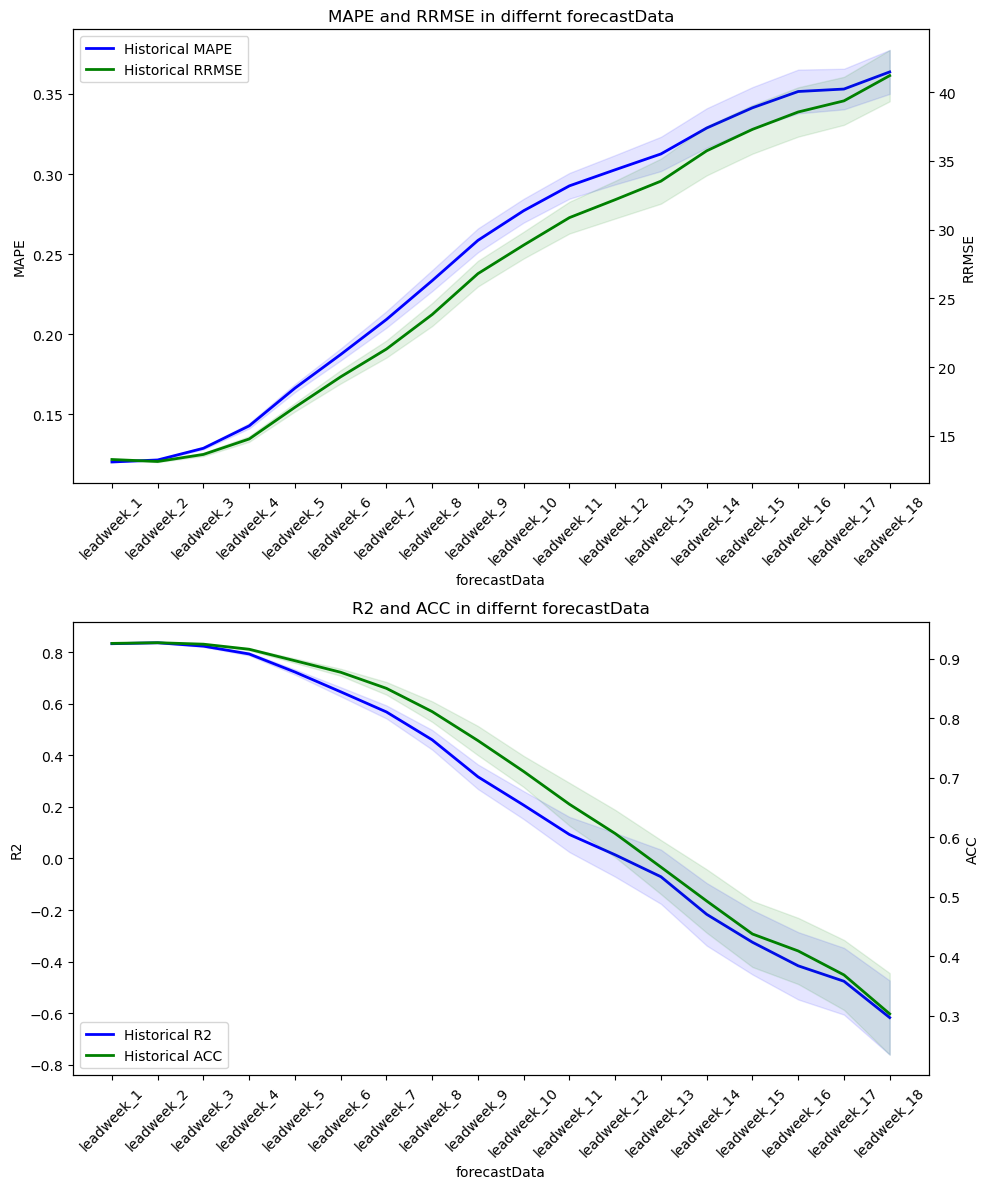

In [13]:
for region in regions:
    # 所有年汇聚到一起
    dataframe_his_0913 = pd.read_csv(os.path.join(inputpath_base,  '03_results',modelname,region,str(Forecastyear)+'his.csv'))
    metrics_his = ['predicts', 'records', 'year', 'forecastData', 'hist']
    grouped_his = dataframe_his_0913[metrics_his].groupby(['forecastData', 'hist'])   
    mape_values_his = grouped_his.apply(
        lambda group: mean_absolute_percentage_error(group['records'], group['predicts'])
    ).reset_index(name='MAPE')
    
    ACC_values_his = grouped_his.apply(
        lambda group: calculate_acc(group['records'], group['predicts'])
    ).reset_index(name='ACC')
    
    r2_values_his = grouped_his.apply(
        lambda group: r2_score(group['records'], group['predicts'])
    ).reset_index(name='R2')
    
    rrmse_values_his = grouped_his.apply(
        lambda group: calculate_rrmse1(group['records'], group['predicts'])
    ).reset_index(name='RRMSE')

    accuracy_his = mape_values_his.merge(ACC_values_his, on=['forecastData', 'hist'], suffixes=('', '_ACC')) \
                                  .merge(r2_values_his, on=['forecastData', 'hist'], suffixes=('', '_R2')) \
                                  .merge(rrmse_values_his, on=['forecastData', 'hist'], suffixes=('', '_RRMSE'))
    
    # 如果生成了多余后缀列，可以选择性删除：
    accuracy_his = accuracy_his.loc[:, ~accuracy_his.columns.str.endswith(('_ACC', '_R2', '_RRMSE'))]

    accuracy_his['week'] = accuracy_his['forecastData'].apply(lambda x: int(x.split('_')[-1]))  # 提取week数字
    accuracy_his = accuracy_his.sort_values(by='week').drop(columns='week')  # 排序并移除临时列

    
    required_columns = ['RRMSE', 'MAPE', 'R2', 'ACC', 'forecastData']
    for df, name in zip([accuracy_his], ['accuracy_his']):
        if not all(col in df.columns for col in required_columns):
            raise ValueError(f"{name} 数据框必须包含以下列: {required_columns}")
    
    # 选择相关列并按 'forecastData' 分组计算均值和标准差
    grouped_his = accuracy_his[['MAPE','ACC','R2','RRMSE','forecastData']].groupby('forecastData').agg(['mean', 'std'])[['RRMSE', 'MAPE', 'R2', 'ACC']]
    grouped_his = accuracy_his[['MAPE', 'ACC', 'R2', 'RRMSE', 'forecastData']].groupby('forecastData').agg(['mean', 'std'])
    
    # 只选择需要的列 (RRMSE, MAPE, R2, ACC)
    grouped_his = grouped_his[['RRMSE', 'MAPE', 'R2', 'ACC']]
    grouped_his['week'] = grouped_his.index.to_list()  # 获取索引列表
    grouped_his['week'] = [int(x.split('_')[-1]) for x in grouped_his['week']]  # 使用列表推导式提取 week 数字
    
    # 按照 week 列排序，并删除 week 列
    grouped_his = grouped_his.sort_values(by='week').drop(columns='week')
    
    
    
    
    # h绘制图
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    # ----------- 第一个子图: MAPE 和 RRMSE -----------
    # 绘制历史数据的 MAPE 均值和标准差范围
    ax1.plot(grouped_his.index , grouped_his['MAPE']['mean'] , color='blue', label='Historical MAPE', linewidth=2)
    ax1.fill_between(
        grouped_his.index,
        grouped_his['MAPE']['mean']  - grouped_his['MAPE']['std'] ,
        grouped_his['MAPE']['mean']  + grouped_his['MAPE']['std'] ,
        alpha=0.1, color='blue'
    )
    ax1.set_ylabel('MAPE')
    
    
    
    # 创建共享 x 轴的第二个 y 轴用于 RRMSE
    ax1_twin = ax1.twinx()
    # 绘制历史数据的 RRMSE 均值和标准差范围
    ax1_twin.plot(grouped_his.index , grouped_his['RRMSE']['mean'] , color='green', label='Historical RRMSE', linewidth=2)
    ax1_twin.fill_between(
        grouped_his.index ,
        grouped_his['RRMSE']['mean'] - grouped_his['RRMSE']['std'] ,
        grouped_his['RRMSE']['mean'] + grouped_his['RRMSE']['std'] ,
        alpha=0.1, color='green'
    )
    ax1_twin.set_ylabel('RRMSE')
    
    
    
    # 设置标题和标签
    ax1.set_title('MAPE and RRMSE in differnt forecastData')
    ax1.set_xlabel('forecastData')
    
    # 合并图例
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax1_twin.get_legend_handles_labels()
    ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left')
    
    ax1.set_xticklabels(grouped_his.index, rotation=45)
    
    # ----------- 第二个子图: R2 和 ACC -----------
    # 绘制历史数据的 R2 均值和标准差范围
    ax2.plot(grouped_his.index, grouped_his['R2']['mean'], color='blue', label='Historical R2', linewidth=2)
    ax2.fill_between(
        grouped_his.index ,
        grouped_his['R2']['mean']  - grouped_his['R2']['std'] ,
        grouped_his['R2']['mean']  + grouped_his['R2']['std'] ,
        alpha=0.1, color='blue'
    )
    ax2.set_ylabel('R2')
    
    
    
    # 创建共享 x 轴的第二个 y 轴用于 ACC
    ax2_twin = ax2.twinx()
    # 绘制历史数据的 ACC 均值和标准差范围
    ax2_twin.plot(grouped_his.index , grouped_his['ACC']['mean'] , color='green', label='Historical ACC', linewidth=2)
    ax2_twin.fill_between(
        grouped_his.index ,
        grouped_his['ACC']['mean']  - grouped_his['ACC']['std'] ,
        grouped_his['ACC']['mean']  + grouped_his['ACC']['std'] ,
        alpha=0.1, color='green'
    )
    ax2_twin.set_ylabel('ACC')
    
    
    
    # 设置标题和标签
    ax2.set_title('R2 and ACC in differnt forecastData')
    ax2.set_xlabel('forecastData')
    
    # 合并图例
    handles3, labels3 = ax2.get_legend_handles_labels()
    handles4, labels4 = ax2_twin.get_legend_handles_labels()
    ax2.legend(handles3 + handles4, labels3 + labels4, loc='lower left')
    ax2.set_xticklabels(grouped_his.index, rotation=45)
    # 自动调整布局以防止重叠
    plt.tight_layout()
    # plt.savefig(filename)
    # 显示图表
    plt.show()

In [14]:
##################################代入预报数据集#############################################################
numbers=11
for region in regions:
    outpathmodel = os.path.join(inputpath_base,'04_model',region, 'LSTM')
    ###################读取所选因子变量#########################################
    Forecastyear = Forecastyears[region]
    data= pd.read_csv(os.path.join(inputpath_base, '01_data','05_buildmodel','05_modeldataNew',region+'_data_new.csv'))
    TimeFeatures_sel, Static_sel, regionID = SelFeature_infornamtion[SelFeature_infornamtion['regionID'] == region].iloc[0]
    feature_all = TimeFeatures_sel+Static_sel
    filtered_columns = [col for col in data.columns if any(feature in col for feature in feature_all)]
    

    ####去掉前几年的产量，可核对精度是否变化#########################
    filtered_columns = [col for col in filtered_columns if 'Yield' not in col] # 去掉产量相关性试试
    Static_sel= [col for col in Static_sel if 'Yield' not in col] # 去掉产量相关性试试
    feature_all = [col for col in feature_all if 'Yield' not in col] # 去掉产量相关性试试

    
    MLdata_reduced = data[filtered_columns+[yield_type]]
    MLdata_reduced['year'] = data['year']
    # 读取所选周数
    inpath_dates = os.path.join(inputpath_base, '01_data','05_buildmodel', '02_extractdates','gs_three_periods.txt')
    gs_infornamtion = pd.read_csv(inpath_dates, delim_whitespace=True, header=None)
    gs_infornamtion.columns = ['start_point', 'peak', 'harvest_point', 'VI_select2','regionID']
    start_point, peak, harvest_point, VI_select2, region = gs_infornamtion[gs_infornamtion['regionID'] == region].iloc[0]
    ############################调参数据准备###########################################################
    data_all = MLdata_reduced;X_all = data_all.drop([yield_type], axis=1);
    
    y_all = data_all[yield_type];
    # 数据标准化
    scaler_X = StandardScaler().fit(X_all)
    X = scaler_X.transform(X_all)
    
    scaler_y = StandardScaler().fit(y_all.values.reshape(-1, 1))
    y = scaler_y.transform(y_all.values.reshape(-1, 1)).flatten()
    
    # 模型导出
    model_path = os.path.join(outpathmodel,region+'my_lstm_model.keras')
    model = load_model(model_path)
    
   ###################################################S2S数据数据集###################################################
    S2SDataList = os.listdir(os.path.join(inputpath_base,'02_S2S','06_buildmodel','01_S2S','VI_Like',region))
    ECMWF_path = os.path.join(inputpath_base,'02_S2S')
    dataframe_S2S_0913 = pd.DataFrame()
    if start_point>harvest_point:
        weeks_select_list= list(range(start_point, 47))+list(range(1, harvest_point+1))
    else:
        weeks_select_list= list(range(start_point,harvest_point+1))
        
    for ii in S2SDataList:
        inputpath_S2S = os.path.join(ECMWF_path,'06_buildmodel', '01_S2S','VI_Like', region,ii)
        # 预测结果输出
        outpath_S2S = os.path.join(ECMWF_path,'06_Results', '01_S2S', ii)
        os.makedirs(outpath_S2S,exist_ok=True)
        # 代入每个预报期下过去30年的历史数据
        for number in range(0,numbers):
            data_S2S_new = pd.read_csv(os.path.join(inputpath_S2S,'number'+ str(number) + '.csv'))
            data_S2S_new = data_S2S_new.merge(data[['year','idJoin']],on=['year','idJoin'],how='inner')
            data_S2S_new['actual_yield']= data_S2S_new['Yield']
            Forecast_S2S = data_S2S_new[filtered_columns+[yield_type]]
            Forecast_S2S['year'] = Forecastyear
            X_test = Forecast_S2S.drop([yield_type], axis=1);y_test = Forecast_S2S[yield_type]
            
            X_test = scaler_X.transform(X_test)
            y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()
            data_list = []
            
            X_test = pd.DataFrame(data=X_test,columns=X_all.columns.tolist())
            for i in weeks_select_list:
                data_i = X_test[[f'Week{i}_{feature}' for feature in TimeFeatures_sel] + Static_sel]
                data_list.append(data_i.values)
            data_list = np.array(data_list)
            X_test_lstm = np.transpose(data_list, (1, 0, 2)) # 将数组重组为samples， time steps, features
            
            y_pred = model.predict(X_test_lstm)
            y_pred_inverse = scaler_y.inverse_transform(y_pred)
            y_test_inverse = scaler_y.inverse_transform(y_test.reshape(-1, 1))
            data_pre = pd.DataFrame({'predicts':y_pred_inverse.ravel(),'records':y_test_inverse.ravel()})
            
            data_pre['year'] = Forecastyear
            data_pre['idJoin'] = data_S2S_new['idJoin'].values
            data_pre['number'] = number
            data_pre['forecastData'] = ii
            data_pre.to_csv(os.path.join(outpath_S2S,'S2S_'+str(Forecastyear)+'_'+'number'+ str(number)+'.csv'),index=False)
            dataframe_S2S_0913 = pd.concat([dataframe_S2S_0913,data_pre], axis=0)       
    dataframe_S2S_0913.to_csv(os.path.join(inputpath_base,  '03_results',modelname,region,str(Forecastyear)+'number'+ str(number)+'.csv'))

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━

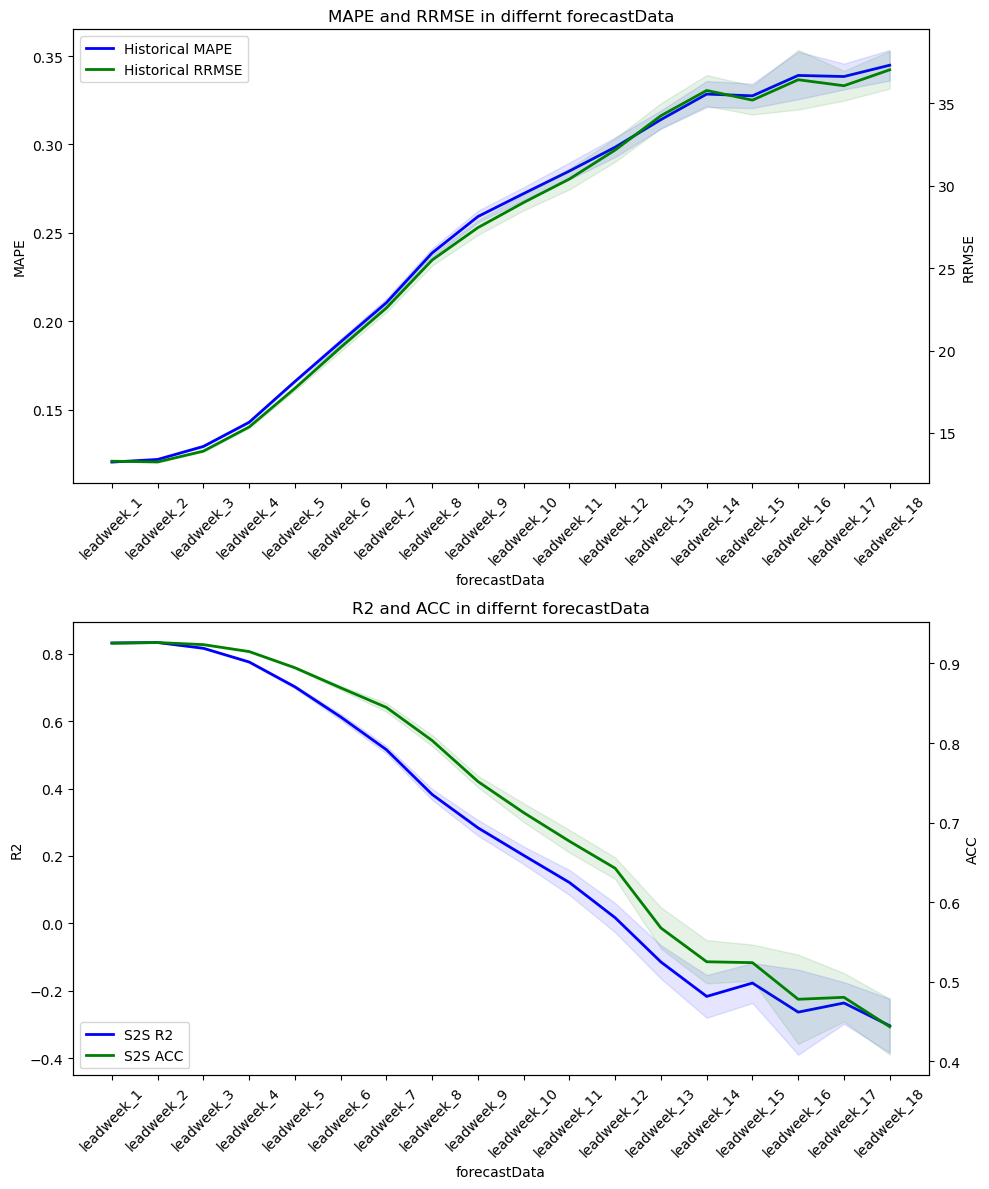

In [15]:
for region in regions:
    # 所有年汇聚到一起
    dataframe_S2S_0913 = pd.read_csv(os.path.join(inputpath_base,  '03_results',modelname,region,str(Forecastyear)+'number'+ str(number)+'.csv'))
    metrics_S2S = ['predicts', 'records', 'year', 'forecastData', 'number']
    grouped_S2S = dataframe_S2S_0913[metrics_S2S].groupby(['forecastData', 'number'])   
    mape_values_S2S = grouped_S2S.apply(
        lambda group: mean_absolute_percentage_error(group['records'], group['predicts'])
    ).reset_index(name='MAPE')
    
    ACC_values_S2S = grouped_S2S.apply(
        lambda group: calculate_acc(group['records'], group['predicts'])
    ).reset_index(name='ACC')
    
    r2_values_S2S = grouped_S2S.apply(
        lambda group: r2_score(group['records'], group['predicts'])
    ).reset_index(name='R2')
    
    rrmse_values_S2S = grouped_S2S.apply(
        lambda group: calculate_rrmse1(group['records'], group['predicts'])
    ).reset_index(name='RRMSE')

    accuracy_S2S = mape_values_S2S.merge(ACC_values_S2S, on=['forecastData', 'number']) \
                                  .merge(r2_values_S2S, on=['forecastData', 'number']) \
                                  .merge(rrmse_values_S2S, on=['forecastData', 'number'])
    accuracy_S2S['week'] = accuracy_S2S['forecastData'].apply(lambda x: int(x.split('_')[-1]))  # 提取week数字
    accuracy_S2S = accuracy_S2S.sort_values(by='week').drop(columns='week')  # 排序并移除临时列

    
    required_columns = ['RRMSE', 'MAPE', 'R2', 'ACC', 'forecastData']
    for df, name in zip([accuracy_S2S], ['accuracy_S2S']):
        if not all(col in df.columns for col in required_columns):
            raise ValueError(f"{name} 数据框必须包含以下列: {required_columns}")
    
    # 选择相关列并按 'forecastData' 分组计算均值和标准差
    grouped_S2S = accuracy_S2S[['MAPE','ACC','R2','RRMSE','forecastData']].groupby('forecastData').agg(['mean', 'std'])[['RRMSE', 'MAPE', 'R2', 'ACC']]
    grouped_S2S = accuracy_S2S[['MAPE', 'ACC', 'R2', 'RRMSE', 'forecastData']].groupby('forecastData').agg(['mean', 'std'])
    
    # 只选择需要的列 (RRMSE, MAPE, R2, ACC)
    grouped_S2S = grouped_S2S[['RRMSE', 'MAPE', 'R2', 'ACC']]
    grouped_S2S['week'] = grouped_S2S.index.to_list()  # 获取索引列表
    grouped_S2S['week'] = [int(x.split('_')[-1]) for x in grouped_S2S['week']]  # 使用列表推导式提取 week 数字
    
    # 按照 week 列排序，并删除 week 列
    grouped_S2S = grouped_S2S.sort_values(by='week').drop(columns='week')
    
    
    
    
    # h绘制图
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    # ----------- 第一个子图: MAPE 和 RRMSE -----------
    # 绘制历史数据的 MAPE 均值和标准差范围
    ax1.plot(grouped_S2S.index , grouped_S2S['MAPE']['mean'] , color='blue', label='Historical MAPE', linewidth=2)
    ax1.fill_between(
        grouped_S2S.index,
        grouped_S2S['MAPE']['mean']  - grouped_S2S['MAPE']['std'] ,
        grouped_S2S['MAPE']['mean']  + grouped_S2S['MAPE']['std'] ,
        alpha=0.1, color='blue'
    )
    ax1.set_ylabel('MAPE')
    
    
    
    # 创建共享 x 轴的第二个 y 轴用于 RRMSE
    ax1_twin = ax1.twinx()
    # 绘制历史数据的 RRMSE 均值和标准差范围
    ax1_twin.plot(grouped_S2S.index , grouped_S2S['RRMSE']['mean'] , color='green', label='Historical RRMSE', linewidth=2)
    ax1_twin.fill_between(
        grouped_S2S.index ,
        grouped_S2S['RRMSE']['mean'] - grouped_S2S['RRMSE']['std'] ,
        grouped_S2S['RRMSE']['mean'] + grouped_S2S['RRMSE']['std'] ,
        alpha=0.1, color='green'
    )
    ax1_twin.set_ylabel('RRMSE')
    
    
    
    # 设置标题和标签
    ax1.set_title('MAPE and RRMSE in differnt forecastData')
    ax1.set_xlabel('forecastData')
    
    # 合并图例
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax1_twin.get_legend_handles_labels()
    ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left')
    
    ax1.set_xticklabels(grouped_S2S.index, rotation=45)
    
    # ----------- 第二个子图: R2 和 ACC -----------
    # 绘制历史数据的 R2 均值和标准差范围
    ax2.plot(grouped_S2S.index, grouped_S2S['R2']['mean'], color='blue', label='S2S R2', linewidth=2)
    ax2.fill_between(
        grouped_S2S.index ,
        grouped_S2S['R2']['mean']  - grouped_S2S['R2']['std'] ,
        grouped_S2S['R2']['mean']  + grouped_S2S['R2']['std'] ,
        alpha=0.1, color='blue'
    )
    ax2.set_ylabel('R2')
    
    
    
    # 创建共享 x 轴的第二个 y 轴用于 ACC
    ax2_twin = ax2.twinx()
    # 绘制历史数据的 ACC 均值和标准差范围
    ax2_twin.plot(grouped_S2S.index , grouped_S2S['ACC']['mean'] , color='green', label='S2S ACC', linewidth=2)
    ax2_twin.fill_between(
        grouped_S2S.index ,
        grouped_S2S['ACC']['mean']  - grouped_S2S['ACC']['std'] ,
        grouped_S2S['ACC']['mean']  + grouped_S2S['ACC']['std'] ,
        alpha=0.1, color='green'
    )
    ax2_twin.set_ylabel('ACC')
    
    
    
    # 设置标题和标签
    ax2.set_title('R2 and ACC in differnt forecastData')
    ax2.set_xlabel('forecastData')
    
    # 合并图例
    handles3, labels3 = ax2.get_legend_handles_labels()
    handles4, labels4 = ax2_twin.get_legend_handles_labels()
    ax2.legend(handles3 + handles4, labels3 + labels4, loc='lower left')
    ax2.set_xticklabels(grouped_S2S.index, rotation=45)
    # 自动调整布局以防止重叠
    plt.tight_layout()
    # plt.savefig(filename)
    # 显示图表
    plt.show()

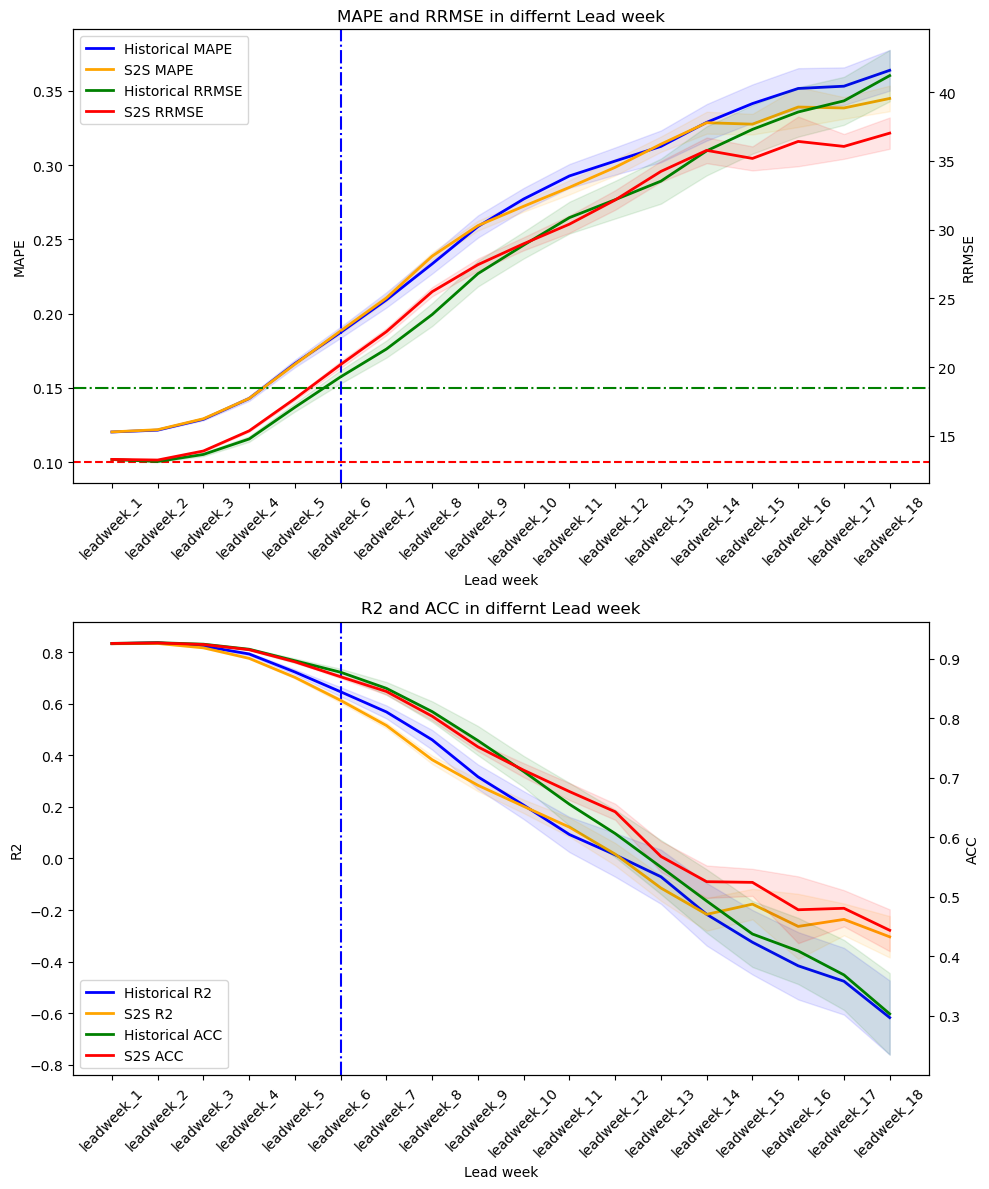

In [16]:
def plot_compare_S2S_hist_week(accuracy_his, accuracy_S2S):#filename
    """
    比较不同 Lead week 下历史数据与 S2S 数据的四种精度指标（RRMSE, MAPE, R2, ACC）。

    参数:
    - accuracy_his: pandas DataFrame，包含历史数据，必须包含以下列 ['RRMSE', 'MAPE', 'R2', 'ACC', 'Lead week']
    - accuracy_S2S: pandas DataFrame，包含 S2S 数据，必须包含以下列 ['RRMSE', 'MAPE', 'R2', 'ACC', 'Lead week']
    
    示例:
    plot_compare_S2S_hist_week(accuracy_his_df, accuracy_S2S_df)
    """
    
    # 确保 'Lead week' 列存在
    required_columns = ['RRMSE', 'MAPE', 'R2', 'ACC', 'Lead week']
    for df, name in zip([accuracy_his, accuracy_S2S], ['accuracy_his', 'accuracy_S2S']):
        if not all(col in df.columns for col in required_columns):
            raise ValueError(f"{name} 数据框必须包含以下列: {required_columns}")
    
    # 选择相关列并按 'Lead week' 分组计算均值和标准差
    grouped_his = accuracy_his[['MAPE','ACC','R2','RRMSE','Lead week']].groupby('Lead week').agg(['mean', 'std'])[['RRMSE', 'MAPE', 'R2', 'ACC']]
    grouped_S2S = accuracy_S2S[['MAPE','ACC','R2','RRMSE','Lead week']].groupby('Lead week').agg(['mean', 'std'])[['RRMSE', 'MAPE', 'R2', 'ACC']]
    
    # 创建2行1列的子图布局
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    # ----------- 第一个子图: MAPE 和 RRMSE -----------
    # 绘制历史数据的 MAPE 均值和标准差范围
        # 只选择需要的列 (RRMSE, MAPE, R2, ACC)
    grouped_his = grouped_his[['RRMSE', 'MAPE', 'R2', 'ACC']]
    grouped_his['week'] = grouped_his.index.to_list()  # 获取索引列表
    grouped_his['week'] = [int(x.split('_')[-1]) for x in grouped_his['week']]  # 使用列表推导式提取 week 数字
    grouped_his = grouped_his.sort_values(by='week').drop(columns='week')


    grouped_S2S = grouped_S2S[['RRMSE', 'MAPE', 'R2', 'ACC']]
    grouped_S2S['week'] = grouped_S2S.index.to_list()  # 获取索引列表
    grouped_S2S['week'] = [int(x.split('_')[-1]) for x in grouped_S2S['week']]  # 使用列表推导式提取 week 数字
    grouped_S2S = grouped_S2S.sort_values(by='week').drop(columns='week')

    
    ax1.plot(grouped_his.index, grouped_his['MAPE']['mean'], color='blue', label='Historical MAPE', linewidth=2)
    ax1.fill_between(
        grouped_his.index,
        grouped_his['MAPE']['mean'] - grouped_his['MAPE']['std'],
        grouped_his['MAPE']['mean'] + grouped_his['MAPE']['std'],
        alpha=0.1, color='blue'
    )
    ax1.set_ylabel('MAPE')
    
    # 绘制 S2S 数据的 MAPE 均值和标准差范围
    ax1.plot(grouped_S2S.index, grouped_S2S['MAPE']['mean'], color='orange', label='S2S MAPE', linewidth=2)
    ax1.fill_between(
        grouped_S2S.index,
        grouped_S2S['MAPE']['mean'] - grouped_S2S['MAPE']['std'],
        grouped_S2S['MAPE']['mean'] + grouped_S2S['MAPE']['std'],
        alpha=0.1, color='orange'
    )
    ax1.axhline(y=0.1, color='r', linestyle='--')  # 红色虚线
    ax1.axhline(y=0.15, color='g', linestyle='-.')  # 绿色点划线
    # ax1.axhline(y=20, color='b', linestyle='-')   # 蓝色实线   
    ax1.axvline(x='leadweek_6', color='b', linestyle='-.')   # 蓝色实线   
    # 创建共享 x 轴的第二个 y 轴用于 RRMSE
    ax1_twin = ax1.twinx()
    # 绘制历史数据的 RRMSE 均值和标准差范围
    ax1_twin.plot(grouped_his.index, grouped_his['RRMSE']['mean'], color='green', label='Historical RRMSE', linewidth=2)
    ax1_twin.fill_between(
        grouped_his.index,
        grouped_his['RRMSE']['mean'] - grouped_his['RRMSE']['std'],
        grouped_his['RRMSE']['mean'] + grouped_his['RRMSE']['std'],
        alpha=0.1, color='green'
    )
    ax1_twin.set_ylabel('RRMSE')
    
    # 绘制 S2S 数据的 RRMSE 均值和标准差范围
    ax1_twin.plot(grouped_S2S.index, grouped_S2S['RRMSE']['mean'], color='red', label='S2S RRMSE', linewidth=2)
    ax1_twin.fill_between(
        grouped_S2S.index,
        grouped_S2S['RRMSE']['mean'] - grouped_S2S['RRMSE']['std'],
        grouped_S2S['RRMSE']['mean'] + grouped_S2S['RRMSE']['std'],
        alpha=0.1, color='red'
    )
    
    # 设置标题和标签
    ax1.set_title('MAPE and RRMSE in differnt Lead week')
    ax1.set_xlabel('Lead week')
    ax1.set_xticklabels(grouped_his.index, rotation=45)
    # 合并图例
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax1_twin.get_legend_handles_labels()
    ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left')
    
    # ----------- 第二个子图: R2 和 ACC -----------
    # 绘R2 均值和标准差范围
    ax2.plot(grouped_his.index, grouped_his['R2']['mean'], color='blue', label='Historical R2', linewidth=2)
    ax2.fill_between(
        grouped_his.index,
        grouped_his['R2']['mean'] - grouped_his['R2']['std'],
        grouped_his['R2']['mean'] + grouped_his['R2']['std'],
        alpha=0.1, color='blue'
    )
    ax2.set_ylabel('R2')
    ax2.axvline(x='leadweek_6', color='b', linestyle='-.')   # 蓝色实线  
    # 绘制 S2S 数据的 R2 均值和标准差范围
    ax2.plot(grouped_S2S.index, grouped_S2S['R2']['mean'], color='orange', label='S2S R2', linewidth=2)
    ax2.fill_between(
        grouped_S2S.index,
        grouped_S2S['R2']['mean'] - grouped_S2S['R2']['std'],
        grouped_S2S['R2']['mean'] + grouped_S2S['R2']['std'],
        alpha=0.1, color='orange'
    )
    
    # 创建共享 x 轴的第二个 y 轴用于 ACC
    ax2_twin = ax2.twinx()
    # 绘制历史数据的 ACC 均值和标准差范围
    ax2_twin.plot(grouped_his.index, grouped_his['ACC']['mean'], color='green', label='Historical ACC', linewidth=2)
    ax2_twin.fill_between(
        grouped_his.index,
        grouped_his['ACC']['mean'] - grouped_his['ACC']['std'],
        grouped_his['ACC']['mean'] + grouped_his['ACC']['std'],
        alpha=0.1, color='green'
    )
    ax2_twin.set_ylabel('ACC')
    
    # 绘制 S2S 数据的 ACC 均值和标准差范围
    ax2_twin.plot(grouped_S2S.index, grouped_S2S['ACC']['mean'], color='red', label='S2S ACC', linewidth=2)
    ax2_twin.fill_between(
        grouped_S2S.index,
        grouped_S2S['ACC']['mean'] - grouped_S2S['ACC']['std'],
        grouped_S2S['ACC']['mean'] + grouped_S2S['ACC']['std'],
        alpha=0.1, color='red'
    )
    
    # 设置标题和标签
    ax2.set_title('R2 and ACC in differnt Lead week')
    ax2.set_xlabel('Lead week')
    ax2.set_xticklabels(grouped_his.index, rotation=45)
    # 合并图例
    handles3, labels3 = ax2.get_legend_handles_labels()
    handles4, labels4 = ax2_twin.get_legend_handles_labels()
    ax2.legend(handles3 + handles4, labels3 + labels4, loc='lower left')
    
    # 自动调整布局以防止重叠
    plt.tight_layout()
    # plt.savefig(filename)
    # 显示图表
    plt.show()
accuracy_S2S1 = accuracy_S2S.copy()
accuracy_his1 = accuracy_his.copy()


accuracy_S2S1.rename(columns={'forecastData': 'Lead week'}, inplace=True)
accuracy_his1.rename(columns={'forecastData': 'Lead week'}, inplace=True)    
plot_compare_S2S_hist_week(accuracy_his1, accuracy_S2S1)

In [ ]:
#参数优化
'''
storage_name =  f"sqlite:///{country}_{country}_{modelname}_region{region}_1007.db"
study_name = f"{country}_{modelname}_region{region}_1007"
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(), study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(objective_LSTM, n_trials=100, n_jobs=4)  # 使用16核CPU进行并行计算
# 输出最佳超参数
print('Best parameters: ', study.best_params)
print('Best MSE: ', study.best_value)

# 加载已经存在的 study
import matplotlib.pyplot as plt
optuna.visualization.plot_param_importances(study)
plt.show()
# 可视化收敛性
df = study.trials_dataframe()
plt.figure(figsize=(12, 6))
plt.plot(df['number'], df['value'])
plt.xlabel('Trial')
plt.ylabel('MSE')
plt.title('Convergence Plot')
plt.grid(True)
plt.show()
'''

[I 2024-12-06 16:32:56,442] A new study created in RDB with name: China_LSTM_regionII_1007


In [6]:
# best_params = {'lstm_epochs': 40, 'lstm_batch_size': 512, 'lstm_n_layers': 3, 'lstm_units': 200, 'lstm_dropout': 0.4, 'lstm_learning_rate': 0.001} #study.best_params#

Epoch 1/75
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.7869 - val_loss: 0.3731
Epoch 2/75
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3720 - val_loss: 0.2318
Epoch 3/75
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2524 - val_loss: 0.2151
Epoch 4/75
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2462 - val_loss: 0.2107
Epoch 5/75
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2596 - val_loss: 0.2055
Epoch 6/75
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.2259 - val_loss: 0.2034
Epoch 7/75
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.2315 - val_loss: 0.2011
Epoch 8/75
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2317 - val_loss: 0.1987
Epoch 9/75
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2180 - val_loss: 0.1963
Epoch 10/75
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2255 - val_loss: 0.1953
Epoch 11/75
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2273 - val_loss: 0.1942
Epoch 12/75
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2

  0%|          | 0/18 [00:00<?, ?it/s]

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━